In [11]:
#Import all necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import datetime

In [12]:
flights = pd.read_csv("data/flights_cleaned.csv")

In [13]:
cities = flights.drop_duplicates('origin_city_name')[['origin_city_name','fl_date']]
cities.rename(columns={'origin_city_name':'city, ST'})

,"city, ST",fl_date
0,"Detroit, MI",2019-05-22
1,"Boston, MA",2019-07-04
2,"New York, NY",2019-06-27
3,"Denver, CO",2018-04-05
4,"Baltimore, MD",2019-02-08
...,...,...
58984,"Bullhead City, AZ",2018-02-03
68378,"Watertown, SD",2019-12-18
74592,"Branson, MO",2018-11-05
74757,"Hyannis, MA",2018-08-15


In [14]:
flights['origin_city_name'].value_counts().sort_values()

Rota, TT                     3
Gustavus, AK                 3
Bullhead City, AZ            3
Ogden, UT                    4
Owensboro, KY                4
                         ...  
Denver, CO               10233
Dallas/Fort Worth, TX    10853
New York, NY             10978
Atlanta, GA              14752
Chicago, IL              17561
Name: origin_city_name, Length: 366, dtype: int64

In [15]:
cities_samp = cities.sample(80)
cities_samp

,origin_city_name,fl_date
79,"Anchorage, AK",2018-03-19
11880,"Waterloo, IA",2018-01-08
12696,"Hattiesburg/Laurel, MS",2019-09-25
133,"Madison, WI",2018-12-27
10081,"Lawton/Fort Sill, OK",2018-05-11
...,...,...
7036,"Staunton, VA",2018-10-11
1135,"San Antonio, TX",2019-08-22
271,"Fayetteville, AR",2019-09-01
0,"Detroit, MI",2019-05-22


In [16]:
weather_data = cities_samp.values.tolist()

In [17]:
weather_data[0][0]

'Anchorage, AK'

In [18]:
url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/weatherdata/history"

weather = []

for i in weather_data:
    
    start_date = datetime.datetime.strptime(i[1], "%Y-%M-%d")
    end_date = start_date + datetime.timedelta(days=1)

    
    querystring = {"contentType":"json",
               "startDateTime":f"{str(start_date.date())}T00:00:00",
               "aggregateHours":"24","location":f"{i[0]}",
               "endDateTime":f"{str(end_date.date())}T00:00:00",
               "unitGroup":"us",
               "key":"UQKQQXNCJ7GE3BLU8R9YITBHS"}
    
    response = requests.request("GET", url, params=querystring)
    weather.append(response.json())

In [19]:
wh_data = []
for i in range(80):
    try:
        wh_data.append(weather[i]['locations'][weather_data[i][0]]['values'][0]['conditions'])
    except:
        wh_data.append(None)

In [20]:
cities_samp['weather'] = wh_data

In [21]:
data = pd.merge(cities_samp, flights[['dep_delay','arr_delay']], left_index=True, right_index=True)

In [22]:
data.isnull().sum()

origin_city_name    0
fl_date             0
weather             1
dep_delay           0
arr_delay           0
dtype: int64

In [23]:
data.dropna(inplace=True)

In [24]:
data.sort_values(['dep_delay','arr_delay'],ascending=False)

,origin_city_name,fl_date,weather,dep_delay,arr_delay
8218,"Portsmouth, NH",2019-06-16,Partially cloudy,245.0,281.0
475,"Mobile, AL",2019-07-29,Rain,105.0,100.0
1791,"Salisbury, MD",2018-05-19,Clear,60.0,45.0
5765,"Pueblo, CO",2018-04-10,Rain,41.0,45.0
570,"Albany, GA",2018-04-16,Clear,41.0,36.0
...,...,...,...,...,...
4212,"Lake Charles, LA",2019-11-24,Clear,-14.0,-31.0
338,"Bend/Redmond, OR",2019-12-10,Clear,-15.0,-1.0
12696,"Hattiesburg/Laurel, MS",2019-09-25,Clear,-17.0,-31.0
16495,"Sitka, AK",2019-07-23,Clear,-22.0,-35.0


In [33]:
we_data = data.groupby('weather',as_index = False)[['dep_delay']].count()
we_data

,weather,dep_delay
0,,1
1,Clear,31
2,Overcast,4
3,Partially cloudy,18
4,Rain,4
5,"Rain, Overcast",10
6,"Rain, Partially cloudy",4
7,Snow,1
8,"Snow, Overcast",2
9,"Snow, Partially cloudy",4


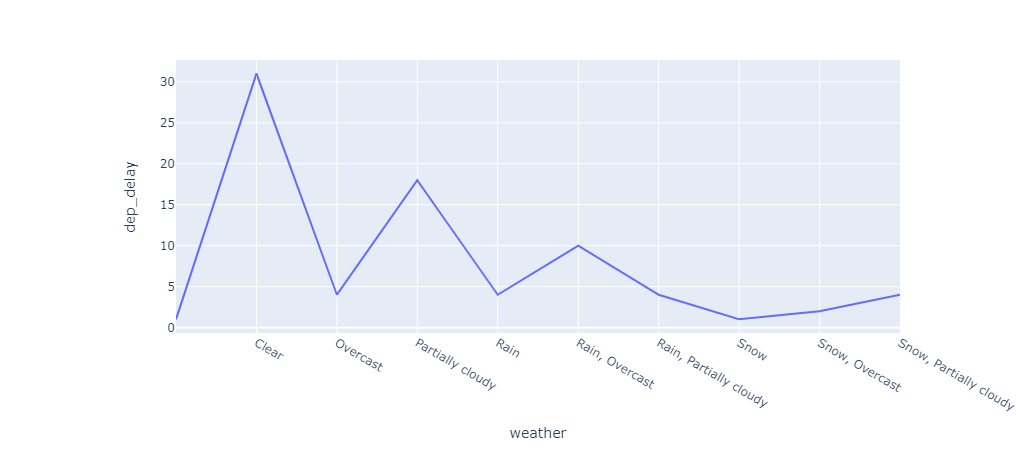

In [34]:
df = px.data.gapminder().query("continent == 'Oceania'")
fig = px.line(we_data, x="weather", y='dep_delay')
fig.show()